In [1]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random 
from scipy.interpolate import RBFInterpolator
from scipy.spatial import KDTree
import numba 

random.seed(0)
warnings.filterwarnings('ignore', category=UserWarning)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Problem Statement

We define the problem in terms of supervised learning. Consider a dataset of $N$ points with $f$ features with two classes, one denoting the point as "unhealthy" and the other as "healthy." 

We apply an AI model (model-agnostic) such that the model learns a decision boundary or contour between the two classes. 

For the problem, we want to find the closest distance from any given unhealthy point to the decision boundary. We mean that among all points in the decision boundary, which point will be closest to the point? 

Additionally, given a set of constraints in $f$ dimensions or fewer, what is the closest point satisfying the constraints to the decision boundary? If constraints are defined for all $f$ dimensions, there would be a box around the original "unhealthy" point. What point lies on the box closest to the decision boundary?

# Goals for the Problem Statement 

1. Find the Decision Boundary for any model defined on a dataset of $N$ points with $f$ within the binary classification case. The Boundary must be model-agnostic and work for any dataset (invariant to the number of features and data points). 
2. We must find the closest distance from a given unhealthy data point (from 1.) to the decision boundary. This must work in any Euclidean space of dimension $R^f$ so that it can work with any dataset. 
3. Given a set of constraints in $f$ dimensions or fewer, what is the closest point satisfying the constraints to the decision boundary? We will show examples in 2D. 

# Importing the Dataset and Creating the Model

Below, we import the SVM dataset into the Jupiter Notebook. This dataset consists of $20$ points, which are one of two classes, either "healthy" or "unhealthy." The "unhealthy" points are colored red, whereas the healthy points are colored blue.

We create an SVM classifier to apply to the SVM dataset.

In [2]:
# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

# Visualizing the Dataset

Below, we show a visualization of the dataset on two features ($x_1$ and $x_2$), and we label each of the data points as one of two classes ("healthy" or "unhealthy")

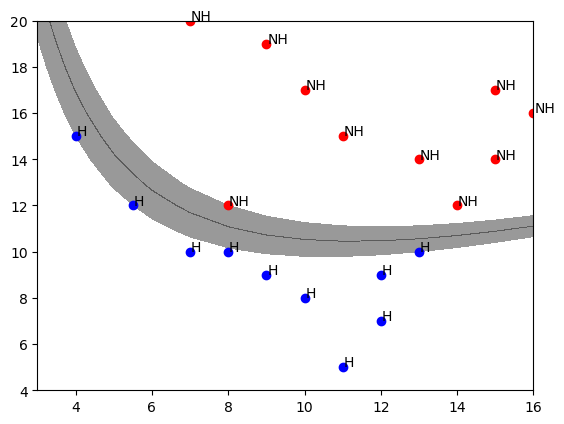

In [3]:
def visualize_dataset():
    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values
    # svm_classifier = svm.SVC(kernel='linear', C=10)
    #svm_classifier = svm.SVC(kernel='poly', C=10)
    svm_classifier = svm.SVC(kernel='poly',C=10, degree=2)
    # svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)
    svm_classifier.fit(X_train, y_train)
    color_ls = []
    for k in y_train:
        if k == 1:
            color_ls.append('b')
        else:
            color_ls.append('r')
    color_ls
    label = []
    for k in y_train:
        if k == 1:
            label.append('H')
        else:
            label.append('NH')
    label
    def plot_decision_boundary(clf, X, y):
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max),np.arange(x2_min, x2_max))
        Z = clf.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        m = np.nonzero(Z < -19)
        Q = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, colors='k', levels=[-1, 0, 1], alpha=0.4,linestyles=['--', '-', '--'])
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        
    plot_decision_boundary(svm_classifier, X_train, y_train)

    for k, (i,j) in enumerate(X_train):
        plt.scatter(i, j, c = color_ls[k])
        plt.text(i+0.02, j+0.02, label[k])

visualize_dataset()

# Closest Point Functions 

```closest_point()``` - computes the closest distance from a point in $R^f$ from the decision boundary usually defined as a numpy array of points in $R^f$ where $f$ is the number of features 

```closest_border_point``` - This computes the closest distance from a set of border points from the decision boundary. Border points are defined with constraints around the original unhealthy point. Generating a box around an unhealthy point will determine the closest distance from the box to the decision boundary.

In [4]:
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    if not isinstance(closest_index, np.int64): 
        closest_index = closest_index[0]
    closest_point = contour[closest_index]
    return closest_point

def closest_border_point(border_points, contour): 
    # Build a KDTree for fast nearest neighbor search
    tree = KDTree(contour) 

    min_point, total_min = None, float('inf')

    for border_point in border_points: 
        # Find the distance and index of the closest contour point using KDTree
        dist, _ = tree.query(border_point)

        # Update the minimum point and distance if a closer point is found
        if dist < total_min: 
            total_min = dist 
            min_point = border_point 
    
    return min_point

# Displacement Function 

```move_from_A_to_B_with_x1_displacement()``` - moves from a given point A to another point B with a displacement value delta 

In [5]:
def move_from_A_to_B_with_x1_displacement(A, B, deltas, epsilon=1e-3):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = deltas / (D + epsilon)   # D[0] is the x1 component of the direction vector
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

[0.49983339 0.49983339 0.49983339]
[3 3 3]
New point P with desired x1 movement: [2.49950017 3.49950017 4.49950017]


# Finding Decision Boundary Points

```compute_decision_boundary_points_all_features()``` -- computes the decision boundary points from a generated mesh grid of points 

```prediction()``` -- Looks for the midpoint between two classes and appends them to a list consisting of boundary points

In [6]:
@numba.njit 
def prediction(Z, grid, epsilon): 
    boundary_points = [] 
    for i in range(len(grid) - 1):
            for j in range(i + 1, len(grid)):
                if np.linalg.norm(grid[i] - grid[j]) < epsilon and Z[i] != Z[j]:
                    boundary_points.append((grid[i] + grid[j]) / 2)  # Midpoint between two classes
    return boundary_points

def compute_decision_boundary_points_all_features(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input pandas dataframe (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        epsilon: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    n_features = X.shape[1]
    # A grid that contains R^f samples from the f dimensional space where f is the number of features
    grid = np.zeros((resolution ** n_features, n_features))

    # Generates a grid that contains R^f samples based on whether the column contains numeric or categorical values 
    # If the column contains numeric types, then the grid generates a column based on subdividing the numeric columns evenly
    for i in range(n_features):
        # Checks if the column is not a column consisting of categorical values
        # If it is not categorical, then the column must be numeric. 
        if not isinstance(X[X.columns[i]].dtype, pd.CategoricalDtype):
            grid[:, i] = np.tile(np.linspace(X.iloc[:, i].min() - 1, X.iloc[:, i].max() + 1, resolution).repeat(resolution ** (n_features - i - 1)), resolution ** i)
        else:
            cat_array = X.iloc[:, i].astype('category').cat.categories
            cat_array = np.arange(len(cat_array))  # e.g., [0, 1, 2] for 3 categories
            repeats_per_cat = resolution ** (n_features - i - 1)
            tiles = resolution ** i
            col_values = np.tile(np.repeat(cat_array, repeats_per_cat), tiles)
            grid[:, i] = col_values
            
    # Predict the class for each point in the grid
    Z = model.predict(grid)
    # Find points near the decision boundary
    boundary_points = prediction(Z, grid, epsilon)
 
    return pd.DataFrame(np.unique(boundary_points,axis=0), columns=X.columns)

# Interpolation, Generating boundaries for a n-dimensional cube 

- RBF Interpolation is used for interpolating scattered data points

```multi_dim_interpolator()``` -- returns an interpolator based on RBF interpolation 

```get_multi_dim_border_points()``` -- generates points on the boundaries of an n-dimensional hyperrectangle/cube 

In [ ]:
def multi_dim_interpolator(boundary_points, N=10000): 
    n_features = boundary_points.shape[1]
    X_vals, y_vals = boundary_points[:N,0:n_features-1], np.reshape(boundary_points[:N,-1], (-1,1)) 
    interpolator = RBFInterpolator(X_vals, y_vals, kernel='cubic', smoothing=1e-2)
    return interpolator 

def generate_add_boundary_pts(X, N=25): 
    n_features = X.shape[1]
    ranges = [np.linspace(X.iloc[:, j].min()-1, X.iloc[:, j].max()+1, N) for j in range(n_features-1)]
    grid_points = np.vstack([r.ravel() for r in ranges]).T
    return grid_points 

def get_multi_dim_border_points(center, extents, step=0.1):
    """
    Generate points on the boundaries of an n-dimensional hyperrectangle.
    
    Parameters:
    - center: List or array of length n, the center of the hyperrectangle.
    - extents: List or array of length n, the half-widths in each dimension.
    - step: Float, step size for sampling points along each dimension.
    
    Returns:
    - List of tuples, each tuple representing a point on the boundary.
    """
    center = np.array(center)
    extents = np.array(extents)
    n = len(center)  # Number of dimensions
    points = set()   # Use set to avoid duplicates
    
    # Define min and max bounds for each dimension
    bounds = [(c - e / 2, c + e / 2) for c, e in zip(center, extents)]
    
    # For each dimension, generate points on the lower and upper boundaries
    for dim in range(n):
        # For lower and upper boundary in this dimension
        for bound_val in [bounds[dim][0], bounds[dim][1]]:
            # Generate grid points for all other dimensions
            other_dims = [i for i in range(n) if i != dim]
            ranges = [np.arange(bounds[i][0], bounds[i][1] + step, step) for i in other_dims]
            if not ranges:  # Handle 1D case
                points.add(tuple([bound_val] if dim == 0 else []))
                continue
            # Create meshgrid for other dimensions
            grids = np.meshgrid(*ranges, indexing='ij')
            coords = [grid.ravel() for grid in grids]
            
            # Construct points
            for coord in zip(*coords):
                point = [0] * n
                # Set the current dimension to the boundary value
                point[dim] = bound_val
                # Set other dimensions to the grid values
                for i, val in zip(other_dims, coord):
                    point[i] = val
                points.add(tuple(point))
    
    return list(points)

def det_constraints(datapt, changes): 
    constraints = [-1] * len(changes) 
    len_constr = 0 
    for i in range(len(changes)): 
        if type(changes[i]) == float or type(changes[i]) == int:
            constraints[i] = (changes[i]/100)*datapt[i]
            len_constr+=1
    return constraints, len_constr

def constraint_bounds(contours, datapt, constraints): 
    if len(constraints) == 0: 
        raise Exception("No constraints were assigned.")
    bounded_contour = contours.copy() 
    for i in range(len(constraints)): 
        if constraints[i] > 0:
            x = datapt[0][i]
            # This should just be the delta
            delta_x = constraints[i]
            # Generate a lower and upper bounds on each constraint
            lowb_x, highb_x = x - (delta_x / 2), x + (delta_x / 2)
            contour_arr = bounded_contour[:, i]
            # Choose the correct indices for the multi-dimensional df
            indices = np.where((contour_arr >= lowb_x) & (contour_arr <= highb_x))
            bounded_contour_pts = bounded_contour[indices]
            bounded_contour = bounded_contour_pts
            if i == 0:
                plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
                plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')
            else: 
                plt.axhline(y=highb_x, color='b', linestyle='-', label='High Bound y')
                plt.axhline(y=lowb_x, color='b', linestyle='-', label='Low bound y')
    return bounded_contour

#constraints = [("gender", "equal"), ("age", "greater"), ("height", "equal"), ("family_history_with_overweight", "equal")]
def real_world_constraints(points, undesired_coords, constraints): 
# [("gender", "equal"), ("age", "greater"), ("height", "equal"), ("family_history_with_overweight", "equal")]
    if len(constraints) == 0: 
        return points 
    
    for constraint in constraints: 
        select_pts = None
        if constraint[1] == "equal": 
            select_pts = points.loc[points[constraint[0]] == undesired_coords[points.columns.get_loc(constraint[0])], :]
        elif constraint[1] == "greater": 
            select_pts = points.loc[points[constraint[0]] > undesired_coords[points.columns.get_loc(constraint[0])], :] 
        else: 
            select_pts = points.loc[points[constraint[0] < undesired_coords[points.columns.get_loc(constraint[0])]], :]

        points = select_pts
    
    return points

# Generating the optimal point

```optimal_point()``` -- generates the boundary point closest to a given "undesired" coordinates (unhealthy point); if given a constraint, it will find the closest point from the box to the contour and/or look for the closest point to the contour depending on selected constraints

```optimal_point()``` should be able to do all of the above goals. So, the function is a process that goes over each goal separately. 

The first goal is to find decision boundary points. Once we have the trained model, we iterate over the points of a grid to determine which points lie at the endpoints of a decision boundary point. 

The function ```compute_decision_boundary_points_all_features()``` generates a $R^f$ grid where $R$ is the number of points in each dimension (equally spaced). Then, it iterates over every point of the grid to figure out which points belong to the decision boundary and which points do not belong to the boundary. 

The second goal is to determine which of the decision boundary points is closest to the indicated unhealthy point (the identifier is "undesired_coords"). Once we have a set of decision boundary points, we iterate over everyone and determine the Euclidean distance from the unhealthy point. 

The function ```closest_point()'' uses KDTrees to determine the closest point on the decision boundary from the given unhealthy point. 

The third and final goal is to set constraints on the original set of features and then determine the closest point following the constraints to the decision boundary. 

The functions ```get_multi_dim_border_points()``` and ```constraint_bounds()``` consider the cases when # of constraints == # of features and # of constraints <  # of features, respectively. 

The first function finds all points on a multidimensional box around the original unhealthy point. Since we determine a closed constraint around each dimension, we just look for all of the points where one of the endpoints is fixed. 

Given that there are no constraints in some dimensions, we look for a decision boundary point or set of decision boundary points that fit all constraints. 

In [14]:
# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(dataset, model, desired_class, original_class, undesired_coords, resolution=100, point_epsilon=0.1, epsilon=0.01, constraints=[], deltas=[]): 
    
    X_train, y_train = dataset.iloc[:, 0:dataset.shape[1]-1], dataset.iloc[:, -1]
    n_features = X_train.shape[1]

    print("fitting model...")
    model.fit(X_train, y_train)
    print("model finished.")

    print("boundary points started generation...")
    boundary_points = compute_decision_boundary_points_all_features(model, X_train, resolution=resolution, epsilon=point_epsilon)
    print("boundary points finished.")

    # Fitting the boundary points to the constraints provided by the real world
    contours = real_world_constraints(points=boundary_points, undesired_coords=undesired_coords, constraints=constraints)
    contours = contours.to_numpy()
    # print("Generating the final contour for multi-dimensional interpolation finished.")
    # contours = boundary_points
    undesired_datapt = np.reshape(np.array(list(undesired_coords)), (1, -1))
    # Find the closest point from the undesired point to the contour line
    print("Finding the closest point from the contour line to the point...")
    optimal_datapt = closest_point(undesired_datapt, contour=contours)
    print("Finding the closest point from the contour line to the point.")
    plt.plot(contours[:,0], contours[:,1], lw=0.5, color='red')

    if desired_class != original_class: 
        D = optimal_datapt - undesired_datapt
        deltas = D * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    else: 
        closest_boundedpt = None
        deltas, len_constr = det_constraints(datapt=undesired_datapt[0], changes=deltas)
        bounded_contour_pts = None
        #print(undesired_datapt.shape)
        if len_constr > n_features: 
            raise Exception("There cannot be more constraints than features")
        elif len_constr == n_features:
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0], extents=deltas, step=0.05)
            np_bounded_contour = np.array(bounded_contour_pts)
            x_values, y_values = np_bounded_contour[:,0], np_bounded_contour[:, 1]
            plt.scatter(x_values, y_values, marker='o')
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=contours)
        else: 
            # Generate bounded contour points
            bounded_contour_pts = constraint_bounds(contours, undesired_datapt, deltas)
            closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)

        D = closest_boundedpt - undesired_datapt
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)
    plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r')
    plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')
    plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'r')
    plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')
    plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')
    return optimal_datapt

fitting model...
model finished.
boundary points started generation...
boundary points finished.
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07131923 1.07023801]]
[[-0.81208054 -4.4966443 ]]


array([[10.13000251, 10.18752037]])

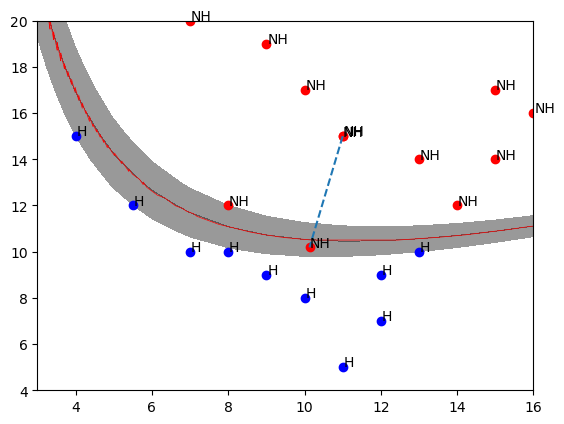

In [256]:
visualize_dataset()
optimal_point(df, svm_classifier, desired_class=1, original_class=-1, resolution=150, undesired_coords=(11,15), point_epsilon=0.1, epsilon=0.07)

# An example of applying the optimal point function 

We apply the optimal point function with the given dataset using a fitted SVM classifier. We return the closest point on the decision boundary from the unhealthy point.

fitting model...
model finished.
boundary points started generation...
boundary points finished.
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00364964 1.0026738 ]]
[[-0.275 -0.375]]


array([[10.72399635, 14.62399733]])

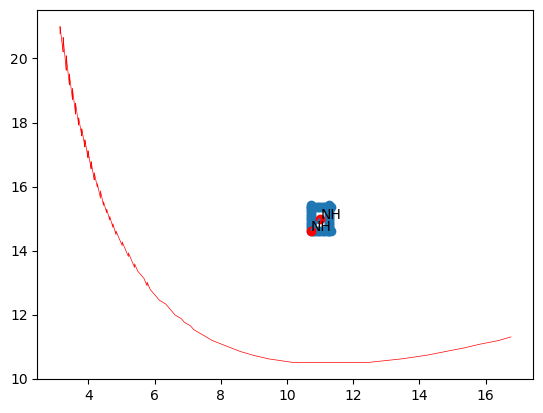

In [16]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, original_class=1, resolution=150, undesired_coords=(11,15), point_epsilon=0.1, epsilon=0.07, constraints=[], deltas=[5,5])
optimal_projection

# Setting Constraints on Each Dimension 

Below, we define the dataset using an SVM classifier, where we specify constraints on each dimension. This means that for the given undesired (unhealthy point) coordinates $(11,15)$, we can define constraints on $x$ and $y$. This means that both $x$ and $y$ are defined within the two bounds $(x - \frac{0.15*x}{2}, x + \frac{0.15*x}{2})$ and $(y - \frac{0.15*y}{2}, y + \frac{0.15*y}{2})$. Below, we set $x = 11$ and $y = 15$, generating the box we see below. 

fitting model...
model finished.
boundary points started generation...
boundary points finished.
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.00121359 1.00088968]]
[[-0.825 -1.125]]


array([[10.17399879, 13.87399911]])

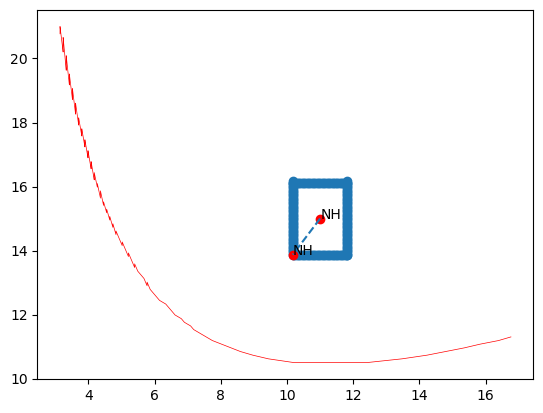

In [17]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, original_class=1, resolution=150, undesired_coords=(11,15), point_epsilon=0.1, epsilon=0.07, constraints=[], deltas=[15,15])
optimal_projection

# Defining in $N$ or fewer dimensions 

Below, we define constraints for a single dimension while letting the other constraint run free. In this case, we define a $15$% constraint around the undesired coordinate y-value while leaving the $x$ coordinate fixed. This means that the y bounds highlighted in blue below are between $(y - \frac{0.15*y}{2}, y + \frac{0.15*y}{2})$. 

Similarly, we can do the same thing while constraining only $x$ and letting $y$ run freely.

In [18]:
optimal_projection = optimal_point(df, svm_classifier, resolution=300, undesired_coords=(11,15), desired_class=-1, point_epsilon=0.1, epsilon=0.01, changes=[None, 15])
optimal_projection

TypeError: optimal_point() got an unexpected keyword argument 'changes'

# Binary Search Approach (Euclidean Space)

Consider an N-dimensional Euclidean space where a given point x is represented as ($x_1$, $x_2$, ..., $x_n$) in the space. 

If we consider two such points, $x_1$ and $x_2$, which are members of different classes, we can find a decision boundary point by performing a binary search. 

Take the midpoint of the two endpoints and evaluate which class the midpoint lies. From that midpoint, it will match one of two endpoints and not the other. Take the midpoint and the non-matching point. Iterate until it is smaller than some epsilon value. 

In [235]:
def alpha_binary_search(model, point, opp_point, point_target, opp_target, epsilon=0.01): 
    start, end = 0, 1
    while abs(end - start) >= epsilon: 
        alpha = (start + end) / 2  # Fix: float division
        temp_candidate = (1 - alpha) * point + alpha * opp_point
        temp_target = model.predict([temp_candidate])[0]
        if temp_target == point_target: 
            start = alpha 
            point_target = temp_target
        elif temp_target == opp_target: 
            end = alpha 
            opp_target = temp_target
    return (start + end) / 2

def find_decision_boundary(model, X, y, epsilon=1e-3, threshold=10000):
    categorical_features = X.select_dtypes(include=int).columns.tolist()
    cat_indices = [X.columns.get_loc(col) for col in categorical_features]

    bool_vec = [1] * (len(X.columns)) 

    for i in range(len(cat_indices)): 
        bool_vec[cat_indices[i]] = 0 

    X_np= X.to_numpy() 
    y_np = y.to_numpy()
    boundary_points = []
    unique_labels = np.unique(y_np)
    if len(unique_labels) != 2:
        raise ValueError("Only supports binary classification.")
    
    label_a, label_b = unique_labels[0], unique_labels[1]
    cluster_a = X_np[y == label_a]
    cluster_b = X_np[y == label_b]

    total_N = 0 
    for i in range(cluster_a.shape[0]):
        point = cluster_a[i]
        for j in range(cluster_b.shape[0]): 
            match_point = cluster_b[j]
            alpha = alpha_binary_search(model, point, match_point, label_a, label_b, epsilon=epsilon)
            boundary = (1 - alpha) * point + alpha * match_point
            boundary_points.append(boundary)
            total_N+=1
            if total_N >= threshold: 
                break
        if total_N >= threshold: 
            break
    
    boundary_pts = pd.DataFrame(data=boundary_points, columns=X.columns)

    for col in categorical_features: 
        boundary_pts[col] = boundary_pts[col].astype(int)

    return boundary_pts

# Revised Optimal Point using Binary Search Approach 

Instead of using the ```optimal_point()``` function with the grid-based approach, we can use the above function to retrieve decision boundary points using the binary search approach. 

We generally choose a small epsilon to find points that best matches those of decision boundary points. 

We changed the parameter ```resolution``` with ```threshold```. ```resolution``` refers to the size of one of the dimensions of a high-dimensional cube whereas ```threshold``` refers to the number of decision boundary points that we want to find using the binary search approach. 

In [236]:
# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(dataset, model, desired_class, original_class, undesired_coords, threshold=10000, point_epsilon=0.1, epsilon=0.01, constraints=[]): 
    
    X_train, y_train = dataset.iloc[:, 0:dataset.shape[1]-1], dataset.iloc[:, -1]
    n_features = X_train.shape[1]

    print("fitting model...")
    model.fit(X_train, y_train)
    print("model finished.")

    print("boundary points started generation...")

    # IMPORTANT # 
    # We are replacing the grid-based approach with the binary search approach
    # Instead of building a grid in N-dimensions, we use binary search to find points on the decision boundary
    boundary_points = find_decision_boundary(model, X_train, y_train, threshold=threshold, epsilon=point_epsilon)
    print("boundary points finished.")
    print(boundary_points.shape)    

    # Fitting the boundary points to the constraints provided by the real world
    contours = real_world_constraints(points=boundary_points, undesired_coords=undesired_coords, constraints=constraints)
    contours = np.unique(contours.to_numpy(),axis=0)
    # print("Generating the final contour for multi-dimensional interpolation finished.")
    # contours = boundary_points
    undesired_datapt = np.reshape(np.array(list(undesired_coords)), (1, -1))
    # Find the closest point from the undesired point to the contour line
    print("Finding the closest point from the contour line to the point...")
    optimal_datapt = closest_point(undesired_datapt, contour=contours)
    print("Finding the closest point from the contour line to the point.")
    #plt.plot(contours[:,0], contours[:,1], lw=0.5, color='red')
    #print(optimal_datapt)
    if desired_class != original_class: 
        D = optimal_datapt - undesired_datapt
        deltas = D * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    else:
        closest_boundedpt = None
        constraints, len_constr = det_constraints(datapt=undesired_datapt[0], changes=constraints)
        bounded_contour_pts = None
        #print(undesired_datapt.shape)
        if len_constr > n_features: 
            raise Exception("There cannot be more constraints than features")
        elif len_constr == n_features:
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0], extents=constraints, step=0.05)
            np_bounded_contour = np.array(bounded_contour_pts)
            x_values, y_values = np_bounded_contour[:,0], np_bounded_contour[:, 1]
            #plt.scatter(x_values, y_values, marker='o')
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=contours)
        else: 
            # Generate bounded contour points
            bounded_contour_pts = constraint_bounds(contours, undesired_datapt, constraints)
            closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)

        D = closest_boundedpt - undesired_datapt
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)
    # plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r')
    # plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')
    # plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'r')
    # plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')
    # plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')
    return optimal_datapt

fitting model...
model finished.
boundary points started generation...
[ 4.38671875 15.64453125]
[ 5.69335938 13.03125   ]
[ 7.        11.6796875]
[ 7.88671875 11.1328125 ]
[ 8.6640625  10.84765625]
boundary points finished.
(5, 2)
         x1         x2
0  4.386719  15.644531
1  5.693359  13.031250
2  7.000000  11.679688
3  7.886719  11.132812
4  8.664062  10.847656
(5, 2)
<class 'numpy.ndarray'>
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07 1.07]]
[[-2.3359375  -4.15234375]]


array([[ 8.50054687, 10.55699219]])

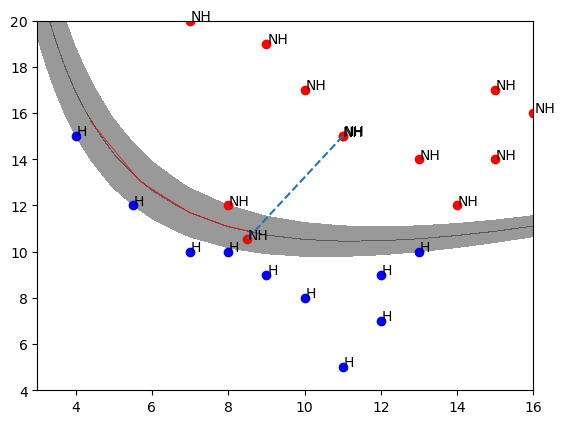

In [95]:
visualize_dataset()
optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=5, undesired_coords=(11,15), point_epsilon=0.01, epsilon=0.07, constraints=[])

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(100, 2)
(100, 2)
<class 'numpy.ndarray'>
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07 1.07]]
[[-0.34765625 -4.49609375]]


array([[10.62800781, 10.18917969]])

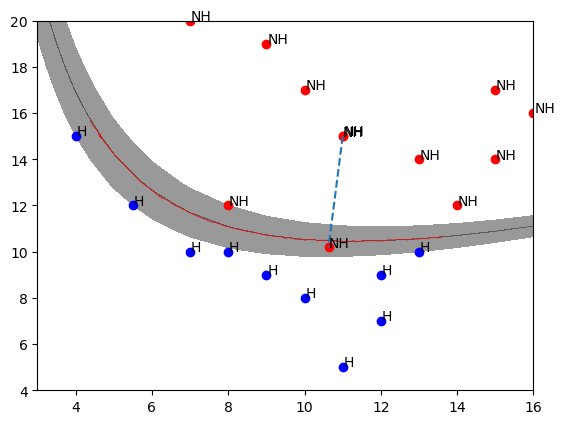

In [44]:
visualize_dataset()
optimal_point(df, svm_classifier, desired_class=1, original_class=-1, threshold=100, undesired_coords=(11,15), point_epsilon=0.01, epsilon=0.07, constraints=[])

# Setting Constraints with Binary Search Approach # 

Similar to before, we can define a set of constraints on both dimensions. This means that both $x$ and $y$ are defined within the two bounds $(x - \frac{0.15*x}{2}, y + \frac{0.15*y}{2})$. Here, we define a $15%$ interval around the point $(x,y)$ using the respective $x$ and $y$ to define the deltas in both directions.

Below, we set $x = 11$ and $y = 15$, generating the box we see below. 

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(100, 2)
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1. 1.]]
[[-0.825 -1.125]]


array([[10.175, 13.875]])

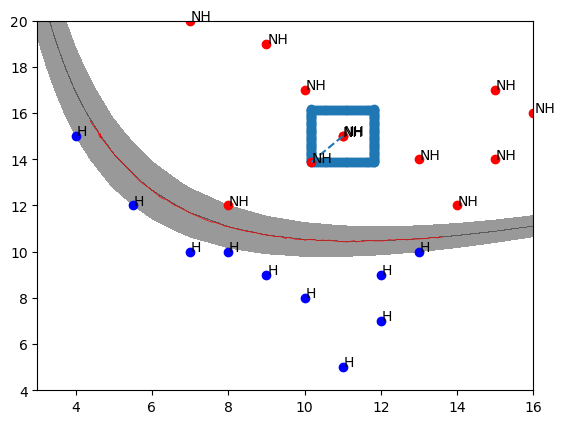

In [32]:
visualize_dataset()
optimal_projection = optimal_point(df, svm_classifier, threshold=100, undesired_coords=(11,15), desired_class=-1, point_epsilon=0.01, epsilon=0.01, changes=[15,15])
optimal_projection

Similarly, we do the same thing with a larger box around the point $(x,y)$, but in this case, we define a $25%$ interval around the point $(x,y)$ in which we define a bound around (x,y) as $(x - \frac{x - 0.25*x}{2}, y + \frac{y + 0.25*y}{2})$. Here, we define a $25%$ interval around the point $(x,y)$ using the respective $x$ and $y$ to define the deltas in both directions.

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(100, 2)
(100, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1. 1.]]
[[-1.375 -1.875]]


array([[ 9.625, 13.125]])

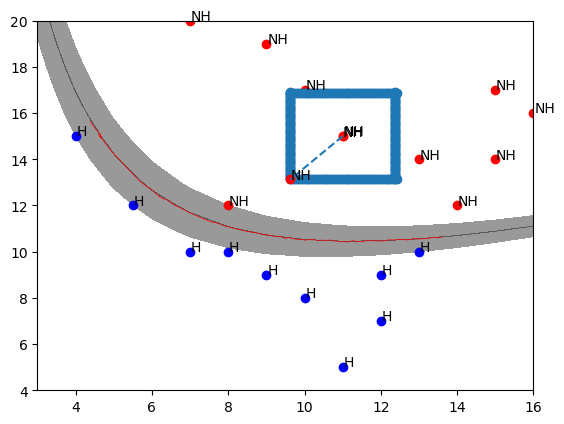

In [33]:
visualize_dataset()
optimal_projection = optimal_point(df, svm_classifier, threshold=100, undesired_coords=(11,15), desired_class=-1, point_epsilon=0.01, epsilon=0.01, changes=[25,25])
optimal_projection

# Obesity Counterfactual Explanations 

The issue of counterfactual explanations is that they require multiple questions to be answered to be feasible & actionable counterfactual explanations. 

1. How do we minimize the change in the feature values and make the observed instance as similar to the original instance (Wachter 2018)? 
2. How do we identify features that change the desired outcome y'? (Pearl ...) We do not want to change features that cannot be "changed" or would be unethical to ask for such a change. Asking for the person to change gender would be unethical. Similarly asking for a person to change their height especially if they are older than 18 would be infeasible. We would want to condition on those variables which affect the value of the outcome Y which we cannot change. 
3. Feasible Constraints (Mahajan 2019; Poyiadzi 2019) -- How do we ensure that the change is "actionable"? Let's say that the person is under the age of 18 and still growing. Does it make sense to change the person's height by a foot for a counterfactual explanation? Can we say that a person should take 50 doses of a given drug every day? We should make changes or treatments reasonable and ethical. 

For this problem, we only address $1$ and $3$. For addressing $2$ in this setting, we use domain knowledge to find features that would make sense to change. For settings that do not have access to domain knowledge, methods such as causal discovery would be able to construct structural causal models necessary to identify such features. 

For this setting, we use a observational dataset of 2000 samples from an obesity dataset. Domain knowledge in this setting is not difficult to obtain. There are four levels of obesity, but in this case, we change the labeling so that obesity levels equate to being obese. In this setting, we deal with a binary classification problem where there are two classes, "normal" or "obese." 

In weight analysis, we can use domain knowledge to our deconstruction of the problem. 

Let's identify the variables which are changeable (actionable) and identify features that change the outcome?


1. Identify features that are actionable (treatment) 

- Gender --> Cannot change (Not able to influence)
- Age --> Can change (cannot decrease age) 
- height --> Cannot change (Not able to influence)
- Weight --> Can change (Able to influence)
- family_history_with_overweight --> not changeable 
- FAVC --> Changeable (Able to influence)
- FCVC --> Changeable (Able to influence)
- CAEC --> Changeable (Able to influence)
- NCP ---> Changeable (Able to influence) 
- SMOKE --> Changeable (Able to influence) 
- CH2O --> Changeable (Able to influence) 
- SCC --> Changeable (Able to influence) 
- FAF --> Changeable (Able to influence) 
- TUE --> Changeable (Able to influence) 
- CALC --> Changeable (Able to influence) 
- MTRANS --> Changeable (Able to influence) 
- Obesity -- Target (Not able to influence; dependent variable)


2. Identify features that affect the outcome 

We use the five most important features selected by the paper (Yagin et. al. 2023). They apply a neural network optimized using Bayesian optimization techniques. 

By mutual information classify, these variables are FAVC, SMOKE, FAF, CALC, FCVC (Yagin et. al. pg 8)

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

obesity_df = pd.read_csv(
'ObesityDataSet_raw_and_data_sinthetic.csv'
)
for col in ['Gender', 'CAEC', 'CALC', 'MTRANS', 'FAVC', 'SMOKE', 'FCVC', 'SCC', 'family_history_with_overweight', 'TUE']:
    obesity_df[col] = LabelEncoder().fit_transform(obesity_df[col])
obesity_df['NObeyesdad'] = (obesity_df['NObeyesdad'] != "Normal_Weight").astype(int)
X = obesity_df.drop('NObeyesdad', axis=1)
y = obesity_df['NObeyesdad']
unique_vals = pd.unique(y)
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [197]:
importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
print(importance.sort_values('Importance', ascending=False))

                           Feature  Importance
3                           Weight    0.283680
2                           Height    0.095884
10                            CH2O    0.084538
12                             FAF    0.081346
0                              Age    0.079115
14                            CAEC    0.069462
13                             TUE    0.057489
6                             FCVC    0.053171
7                              NCP    0.049682
11  family_history_with_overweight    0.038363
15                          MTRANS    0.034813
4                             CALC    0.020734
1                           Gender    0.019780
5                             FAVC    0.017578
8                              SCC    0.009905
9                            SMOKE    0.004460


In [243]:
# "delta" -- setting a delta around the undesired data point 
# "greater" -- the constraint only accepts values greater than a given feature value 
# "less" -- the constraint only accepts values less than a given feature value
# "equal" -- the constraint accepts values equal to a given feature value 

# - Gender --> Cannot change (Not able to influence)
# - Age --> Can change (cannot decrease age) 
# - height --> Cannot change (Not able to influence)
# - Weight --> change (Able to influence)
# - family_history_with_overweight --> not changeable 
# - FAVC --> Changeable (Able to influence)
# - FCVC --> Changeable (Able to influence)
# - CAEC --> Changeable (Able to influence)
# - NCP ---> Changeable (Able to influence) 
# - SMOKE --> Changeable (Able to influence) 
# - CH2O --> Changeable (Able to influence) 
# - SCC --> Changeable (Able to influence) 
# - FAF --> Changeable (Able to influence) 
# - TUE --> Changeable (Able to influence) 
# - CALC --> Changeable (Able to influence) 
# - MTRANS --> Changeable (Able to influence) 
# - Obesity -- Target (Not able to influence; dependent variable)

#constraints = [("gender", "equal"), ("age", "greater"), ("height", "equal"), ("family_history_with_overweight", "equal")]
#constraints= [("gender", "equal"), ("age", "greater"), ("height", "equal")] 
constraints = [("gender", "equal"), ("age", "greater"), ("height", "greater")]

In [199]:
obesity_df.columns = [col.lower() for col in obesity_df.columns]

In [200]:
obesity_df.head(n=20)

,age,gender,height,weight,calc,favc,fcvc,ncp,scc,smoke,ch2o,family_history_with_overweight,faf,tue,caec,mtrans,nobeyesdad
0,21.0,0,1.62,64.0,3,0,170,3.0,0,0,2.0,1,0.0,840,2,3,0
1,21.0,0,1.52,56.0,2,0,809,3.0,1,1,3.0,1,3.0,0,2,3,0
2,23.0,1,1.80,77.0,1,0,170,3.0,0,0,2.0,1,2.0,840,2,3,0
3,27.0,1,1.80,87.0,1,0,809,3.0,0,0,2.0,0,2.0,0,2,4,1
4,22.0,1,1.78,89.8,2,0,170,1.0,0,0,2.0,0,0.0,0,2,3,1
5,29.0,1,1.62,53.0,2,1,170,3.0,0,0,2.0,0,0.0,0,2,0,0
6,23.0,0,1.50,55.0,2,1,809,3.0,0,0,2.0,1,1.0,0,2,2,0
7,22.0,1,1.64,53.0,2,0,170,3.0,0,0,2.0,0,3.0,0,2,3,0
8,24.0,1,1.78,64.0,1,1,809,3.0,0,0,2.0,1,1.0,840,2,3,0
9,22.0,1,1.72,68.0,3,1,170,3.0,0,0,2.0,1,1.0,840,2,3,0


In [201]:
for col in obesity_df.columns: 
    print(col, obesity_df[col].dtype)

age float64
gender int32
height float64
weight float64
calc int32
favc int32
fcvc int64
ncp float64
scc int32
smoke int32
ch2o float64
family_history_with_overweight int32
faf float64
tue int64
caec int32
mtrans int32
nobeyesdad int32


In [202]:
obesity_df.iloc[3,:obesity_df.shape[1]-1]

age                                27.0
gender                              1.0
height                              1.8
weight                             87.0
calc                                1.0
favc                                0.0
fcvc                              809.0
ncp                                 3.0
scc                                 0.0
smoke                               0.0
ch2o                                2.0
family_history_with_overweight      0.0
faf                                 2.0
tue                                 0.0
caec                                2.0
mtrans                              4.0
Name: 3, dtype: float64

In [242]:
constraints

[('gender', 'equal'), ('age', 'greater'), ('height', 'equal')]

In [244]:
optimal_point(obesity_df, svm_classifier, desired_class=0, original_class=1, threshold=250000, undesired_coords=obesity_df.iloc[3,:obesity_df.shape[1]-1], point_epsilon=0.01, epsilon=1e-6, constraints=constraints)

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(250000, 16)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[0.94247703 0.         0.96798137 1.0000644  0.999002   0.999002
  1.00000257 0.         0.         0.         1.55145353 0.999002
  0.99899391 1.00000011 0.         1.00025106]]
[[ 1.63840742e-02  0.00000000e+00  3.02308750e-02 -1.57728229e+01
   1.00000000e+00  1.00000000e+00 -6.37000000e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.81339453e-03  1.00000000e+00
   9.91958687e-01  1.12300000e+03  0.00000000e+00 -4.00000000e+00]]


C:\Users\Compuworld\AppData\Local\Temp\ipykernel_49896\581390928.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  select_pts = points.loc[points[constraint[0]] == undesired_coords[points.columns.get_loc(constraint[0])], :]
C:\Users\Compuworld\AppData\Local\Temp\ipykernel_49896\581390928.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  select_pts = points.loc[points[constraint[0]] > undesired_coords[points.columns.get_loc(constraint[0])], :]


array([[ 2.70154416e+01,  1.00000000e+00,  1.82926292e+00,
         7.12261613e+01,  1.99900200e+00,  9.99001998e-01,
         1.71998363e+02,  3.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.99563515e+00,  9.99001998e-01,
         2.99096069e+00,  1.12300012e+03,  2.00000000e+00,
        -1.00425106e-03]])